# How to Build a Model 

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from src.models.game import NCAAModel
from src.utils import load_target_sample
pd.options.display.float_format = '{:.2f}'.format

## NCAA Model Class

Simply use the `NCAAModel` class that automaticall loads the properly indexed data and has cross-validation Routines preimplemented. 
* Below we will use an XGBClassifier estimator to fit the data. Any classifier that implements the classic sklearn-style `fit()` and `predict_proba()` functions will do. 
* A standard feature pipeline is set for the Model and will be loaded in `__init__` unless you provide `preload=False`.

In [2]:
from xgboost import XGBClassifier

m = NCAAModel(Estimator=XGBClassifier)
m

Running Feature Pipeline
-- Seeds --
(2117, 9)
Feature Pipeline Clock: 0 Seconds
Fit Features Loaded: (2117, 3)
Running Feature Pipeline
-- Seeds --
(2278, 9)
Feature Pipeline Clock: 0 Seconds
Pred Features Loaded: (2278, 3)


### Cross Validation
* Cross validation methods are already impletemented on the model.

In [3]:
m.cross_validate(n_splits=5)

,log_loss,ncaa_log_loss
mean,0.55,0.55
std,0.03,0.03
min,0.51,0.51
max,0.59,0.59


* You can also 'sample' from the cross validation error by running random splits repetitively and look at the results

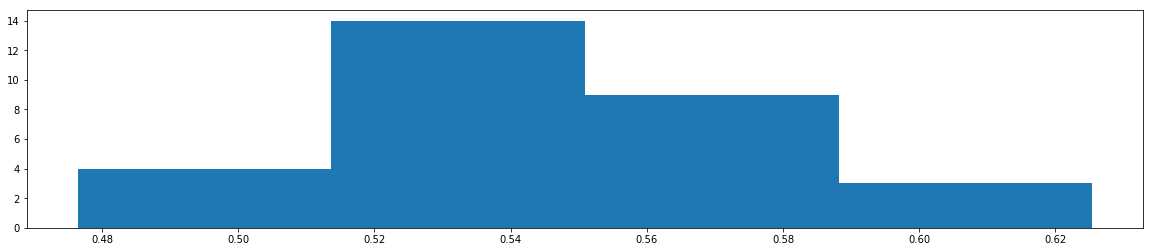

,log_loss,ncaa_log_loss
mean,0.55,0.55
std,0.03,0.03
min,0.48,0.48
max,0.63,0.63


In [4]:
m.cross_validate(n=25, n_splits=10, show_histogram=True)

#### Estimator Parameters

To set the parameters of the estimator for cross-validation (`cross_validate`) or fitting (`fit`, `fit_predict`), simply pass them in form of a `dict` through the `ep` parameter.

In [5]:
m.cross_validate(n=10, n_splits=10, ep={'max_depth': 7, 'subsample': .95, 'n_estimators': 50})

,log_loss,ncaa_log_loss,ep_max_depth,ep_subsample,ep_n_estimators
mean,0.55,0.55,7.00,0.95,50.00
std,0.03,0.03,0.00,0.00,0.00
min,0.51,0.51,7.00,0.95,50.00
max,0.63,0.63,7.00,0.95,50.00


In [6]:
m.cross_validate(n=10, n_splits=10, ep={'max_depth': 1, 'subsample': .75, 'n_estimators': 250})

,log_loss,ncaa_log_loss,ep_max_depth,ep_subsample,ep_n_estimators
mean,0.55,0.55,1.00,0.75,250.00
std,0.05,0.05,0.00,0.00,0.00
min,0.49,0.49,1.00,0.75,250.00
max,0.63,0.63,1.00,0.75,250.00


#### CV History

After fitting the model with different parameters, the history of the cross-validation performance is automatically stored. You can view it through `get_cv_history`. Each cross-validation split is represented as one row. Note that the rows with `nan` are where the estimator was fit with default parameters.

In [7]:
m.get_cv_history().sample(5)

,ep_max_depth,ep_n_estimators,ep_subsample,log_loss,ncaa_log_loss
timestamp,,,,,
2018-03-13 23:24:32.915884,nan,nan,nan,0.54,0.54
2018-03-13 23:24:32.915884,nan,nan,nan,0.51,0.51
2018-03-13 23:24:32.915884,nan,nan,nan,0.63,0.63
2018-03-13 23:24:32.915884,nan,nan,nan,0.56,0.56
2018-03-13 23:24:32.915884,nan,nan,nan,0.49,0.49


In [8]:
m.get_cv_history().fillna('default').groupby(['ep_max_depth', 'ep_n_estimators', 'ep_subsample']).mean()

,,,log_loss,ncaa_log_loss
ep_max_depth,ep_n_estimators,ep_subsample,,
1.0,250.0,0.75,0.55,0.55
7.0,50.0,0.95,0.55,0.55
default,default,default,0.55,0.55


### Custom Features

The default feature pipeline can be overwritten by either adding a `feature_pipeline` function in a subclass of by passing a `feature_pipeline` arguement to the constructor as below.
* A feature_pipeline function takes a data template with `team_a`, `team_b`, `Season`, `DayNum` and target information (e.g. `a_win`)
* The pipeline merges other features onto that template and then returns the teamplate

In [9]:
from datetime import datetime as dt
from src.features import SeedFeatures


def feature_pipeline(data):
    seed_feat = SeedFeatures()
    data = seed_feat.per_team_wrapper(
        data, seed_feat.team_seeds,
        per_game=False, per_day=False)
    return data


m = NCAAModel(feature_pipeline=feature_pipeline, Estimator=XGBClassifier)
m.cross_validate()

Fit Features Loaded: (2117, 3)
Pred Features Loaded: (2278, 3)


,log_loss,ncaa_log_loss
mean,0.55,0.55
std,0.01,0.01
min,0.53,0.53
max,0.56,0.56


### Now All at Once

We can build a model that only looks at the detailed data using a `RandomForestClassifier` from `sklearn`.

**Note: This should work on it's own, just don't forget the `imports`**

In [10]:
from datetime import datetime as dt
from src.features import GameDetailedFeatures
from sklearn.ensemble import RandomForestClassifier


def feature_pipeline(data):
    print('Running Feature Pipeline')
    start = dt.now()

    print('-- Games Detailed --')
    game_detail_feat = GameDetailedFeatures(default_lags=7)
    data = game_detail_feat.per_team_wrapper(
        data, game_detail_feat.detail_features_by_game,
        per_day=True)
    data.dropna(inplace=True)
    print(data.shape)
    
    print('Feature Pipeline Clock: {} Seconds'
      .format((dt.now() - start).seconds))
    return data


m = NCAAModel(feature_pipeline=feature_pipeline, Estimator=RandomForestClassifier)
m.cross_validate(ep={'n_estimators': 100})

Running Feature Pipeline
-- Games Detailed --
(981, 189)
Feature Pipeline Clock: 23 Seconds
Fit Features Loaded: (981, 183)
Running Feature Pipeline
-- Games Detailed --
(2278, 189)
Feature Pipeline Clock: 21 Seconds
Pred Features Loaded: (2278, 183)


,log_loss,ncaa_log_loss,ep_n_estimators
mean,0.29,0.29,100.00
std,0.01,0.01,0.00
min,0.28,0.28,100.00
max,0.30,0.30,100.00


In [12]:
preds = m.fit_predict()
preds.head()

,team_a,team_b,Season,DayNum,a_win,game_set,b_win
ID,,,,,,,
2018_1104_1112,1104,1112,2018,366,0.40,0,0.60
2018_1104_1113,1104,1113,2018,366,0.60,0,0.40
2018_1104_1116,1104,1116,2018,366,0.50,0,0.50
2018_1104_1120,1104,1120,2018,366,0.50,0,0.50
2018_1104_1124,1104,1124,2018,366,0.60,0,0.40
